Strategy: use vocabulary words (clustered in an unsupervised way) to find frequent patterns in forum posts

In [1]:
# Necessary imports
import findspark
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark
from pyspark.ml.fpm import FPGrowth
from pyspark.sql import SparkSession
from pyspark.sql.functions import split
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Ship with sample files
raw_forum_posts = "posts_spreadsheet.xlsx"
pvocab_file = "pvocab.txt"
post_baskets_for_analysis = "pvocab_baskets.txt"

In [ ]:
# Read in Data & keep only post text for now
data = pd.read_excel(raw_forum_posts)
posts_text = data.filter(items=['content'])

# rm posts with no content
posts_text.dropna(subset=['content'],inplace=True)

# rm posts with only non-alpha content 
posts_text['content_type'] = posts_text.apply(lambda x: type(x.content),axis=1)
non_alpha_post_rows = posts_text.loc[posts_text.content_type != posts_text.content_type.value_counts().index[0]]
posts_text.drop(index=non_alpha_post_rows.index,inplace=True)
print("Now have {:d} posts to analyze".format(posts_text.shape[0]))
total_posts = posts_text.shape[0]

Feed in clusters pruned by a human (as in human can "hide" misc. clusters)

Load in a text file of Palavarous vocab by cluster below.
The format of the file is currently like:
```
Nutrition: vitamin, supplement, recipe, dairy, vegetables, fruit, weight, lbs
# Ambiguous:  back (as rear of torso, or "back to drugA") 
```
One can cull the vocab for a market basket analysis just by commenting-out a line of cluster terms ('#' should be first char in line to ignore). IMPORTANT NOTE: posts that don't have any of the fed vocab are REMOVED from the pipeline, so this will narrow the posts you analyze. This means we're saying "Given they are talking about (the tests cluster you fed into vocab), then we're confident they'll talk about (healthcare professionals you fed into vocab). With my trial of ~200 interesting terms, this meant my analysis covered only 70% of available posts, for instance. We'd want to make sure that narrowing of the coverage is communicated clearly to analysts and customers.

Our unsupervised clustering technique already provides helpful word counts, and it would make a lot of sense - when automatically extracting vocabularies in future - to ONLY extract from each selected cluster those vocabulary words that meet some occurrence threshold. There's no point extracting a lot of words that will never meet the minSupport threshold used in the FPGrowth algo below.

In [ ]:
# Load vocab from text file
with open (pvocab_file,'r') as f:
    data = f.readlines()  # list of one string per line
categories = [cluster.split(':') for cluster in data if not cluster.startswith('#')]
pvocab = {category[0]:category[1].strip() for category in categories}
for line in pvocab.keys():
    pvocab[line] = pvocab[line].split(',')
this_vocab = list(pvocab.keys()) # note here I kept the human label e.g. ('Symptoms') as a vocab term; may want this to be a choice
for k in pvocab.keys():
    this_vocab.extend(pvocab[k])
this_vocab = [term.strip().lower() for term in this_vocab]
len_vocab = len(this_vocab)
print('Now we have {:d} words in our vocab'.format(len_vocab))


Turn the above posts into a matrix. (I think of using binary on scikit learn's CountVectorizer as essentially a one hot encoder, BUT this class can be modified to take stop-words, lemmatization, etc., which would help make sure we don't throw away rules like "doctor" --> "drugA" just because a third of the examples used "doctor", another third used "doc", and another third used "dr".)

In [ ]:
# CountVectorize 
count_vector = CountVectorizer(vocabulary = this_vocab, binary=True)
forum_vects = count_vector.fit_transform(posts_text.content)
print('{:d} posts were vectorized and are represented with {} features.'.format(forum_vects.shape[0], forum_vects.shape[1]))

Here I do an inverse transform so token_posts sent into the FPGrowth algo in Spark read as "diapers, beer" instead of "123, 788". This was to make the baskets human-interpretable during the development process, but that's not strictly necessary. As space/network constraints warrant, I've tested (it works just fine) and we can leave the posts represented with integers at runtime, only transforming them back into our vocab words using inverse_transform AFTER baskets/rules get generated.

In [ ]:
# Inverse transformation of posts into vocab representations
ohe_pvocab = count_vector.inverse_transform(forum_vects)
token_posts = [post for post in ohe_pvocab if len(post)>0]
num_matching_posts = len(token_posts)
print("The selected vocabulary eliminates {:.1%} of the provided posts from your analysis".format((total_posts - len(token_posts))/total_posts))
print("Any findings from this tool will represent {:d} total posts altogether".format(num_matching_posts))

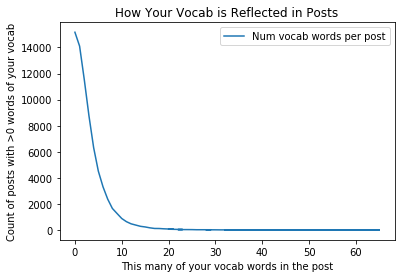

In [7]:
# Visualize post data we'll be keeping
pvocab_ohe = forum_vects.toarray()
post_sums = np.sum(pvocab_ohe, axis=1)
pandify = pd.Series(post_sums)
plt.plot(pandify.value_counts(), label = 'Num vocab words per post')
plt.xlabel('This many of your vocab words in the post')
plt.ylabel('Count of posts with >0 words of your vocab')
plt.title("How Your Vocab is Reflected in Posts")
plt.legend()
plt.show()

In [8]:
# Save matrix off in format easiest to load in spark
baskets = np.array(token_posts)
with open(post_baskets_for_analysis,"w") as f:
    f.write("\n".join(",".join(map(str, x)) for x in baskets))

Begin mining for frequent patterns and association rules in Spark

In [9]:
# Here's the start-up of Spark
findspark.init()

spark = SparkSession.builder \
        .master("local") \
        .appName("PostVocabPatterns") \
        .getOrCreate()

In [ ]:
posts_matrix = post_baskets_for_analysis
data = (spark.read
    .text(posts_matrix)
    .select(split("value", ",").alias("items")))
post_count = data.count()
print(post_count, "count of posts being analyzed for frequent patterns in vocabulary")

In [11]:
# This is where the operation graph is defined (NOT where it is executed)
# See scalability notes below to help pick the minSupport value below
min_support = .003
min_confidence = 0.8
# Further below are notes on the minConfidence.
fp = FPGrowth(minSupport=min_support,minConfidence=min_confidence)
fpm = fp.fit(data)
top_items = fpm.freqItemsets.orderBy(["freq"],ascending = False)

# Scalability Notes
The FPGrowth algorithm builds a special tree (note it is NOT a binary tree) data structure. See this helpful explanation at
[Wikipedia](https://en.wikibooks.org/wiki/Data_Mining_Algorithms_In_R/Frequent_Pattern_Mining/The_FP-Growth_Algorithm)


The algorithm is efficiently lazy as it does NOT add to its tree any leaves that would fail to meet the minSupport criterion. So the higher (between 0 - 1) you set the required support threshold, the fewer leaves it must attach and consider. 

On JenD's laptop, with [masked] posts, minSupport of 1/100 ran just fine, but minSupport of 1/1000 was MUCH slower, sometimes didn't complete. So the higher (between 0 - 1) you set the required minSupport threshold, the fewer leaves it must consider, and the faster the algo will run. 

![FP-tree](https://upload.wikimedia.org/wikipedia/commons/1/1e/FPG_FIG_01.jpg)

In [12]:
# BEWARE: This is the Spark action step, where the tree is grown
# See the Spark UI to watch progress along the DAG
# This algo doesn't have a deterministic BigO notation that I can find, but just building the tree requires 2 passes through the data, plus a frequency sort
post_patterns = top_items.toPandas()

In [13]:
# Quick analysis of patterns and counts
post_patterns.rename(columns={"items": "words"},inplace=True)
print("Detected {} patterns, including unigram word counts (below is patterns observed per word count, starting with unigrams)".format(post_patterns.shape[0]))
post_patterns['numWords'] = post_patterns.apply(lambda x: len(x.words),axis=1)
post_patterns['freq_pct'] = post_patterns.apply(lambda x: 100*x.freq/total_posts,axis=1)
post_patterns.numWords.value_counts().sort_index()

Detected 1094 patterns, including unigram word counts (below is patterns observed per word count, starting with unigrams)


1    173
2    708
3    196
4     17
Name: numWords, dtype: int64

In [ ]:
# Examine sample "baskets" that correspond to "top" listings per word count
print("Top frequent patterns observed per word count (note that freq_pct is dividing by ALL {:d} posts for clarity):".format(total_posts))
for i in range(1,int(post_patterns.numWords.value_counts().index.max()+1)):
    print(post_patterns[post_patterns.numWords== i][0:10])

In [ ]:
# Finally, these are the association rules that were derived
assoc_rules = fpm.associationRules
rules = assoc_rules.toPandas()
num_rules = len(rules)
print("Your full corpus of {:d} posts was narrowed to {:d} posts containing your vocabulary of {:d} words.".format(total_posts,num_matching_posts,len_vocab))
print("{:d} association rules were generated below for your inspection.".format(num_rules))
print("Each pattern was seen in the wild at least {:.0f} times, which is {:.3f} of {}.".format(min_support*num_matching_posts,min_support,num_matching_posts))
print("Given presence of the antecedant, the confidence level listed says we'll see the consequent as well.")
print("Minimum acceptable confidence was set to {:.1%}.".format(min_confidence))
print("ASSOCIATION RULES ******************************")
rules.head(num_rules)

Noe: Lift is a measure of how correlated the consequent is to the antecedent. If the consequent appeared completely independently of the antecedent, the lift would be 1. If the lift is 10 and the confidence is .85, then we're 85% confident that  - given we observe the antecedent in a post - we believe we're 10x more likely than usual to observe the consequent as well. 